In [2]:
from imports import *  
from tools import *

In [3]:
# Get the new HST catalogue
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wclusters.fits' %root_dir)

# Get the Barnes et al. 2021 catalogue
table_b21 = QTable.read('/Users/abarnes/Dropbox/work/Projects/pressures/phangs/data/catalouge/v2/physprops/master.fits') 
for key in table_b21.keys():
    if key == 'region_ID' or key == 'gal_name':
        continue
    table_b21.rename_column(key, key+'_MUSE_B21')
table_all = join(table, table_b21, keys=['region_ID', 'gal_name'])

# Get the full muse catalogue
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table_muse = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir) 

# GET ELECTRON DENSITY

In [4]:
# Function to produce the SII ratio limit vs. temperature function using pyneb... 
# This slightly differs from the one in the Barnes et al. 2021 paper... 
def get_sii_ratio_ll_func(sii_array = np.linspace(1.39, 1.51, 200), t_array = np.linspace(5000, 20000, 10), showplot=False):

    from scipy.interpolate import CubicSpline

    sii_max = np.empty(len(t_array))
    S2 = pn.Atom('S', 2)
    
    for i, t in enumerate(t_array):
        ne = S2.getTemDen(sii_array, tem=t, wave1=6716, wave2=6730)
        if showplot:
            plt.plot(sii_array, ne, label='%0.0f K' %t)
            plt.legend()
        mask = np.where(ne == 1)[0][0]
        sii_max[i] = sii_array[mask]  

    spl = CubicSpline(t_array, sii_max)

    return(spl)

sii_ratio_ll_func = get_sii_ratio_ll_func()

In [5]:
# Simple Gaussian function
def func(x, a, b):
    return a * np.exp(-0.5 * x**2 / b**2)

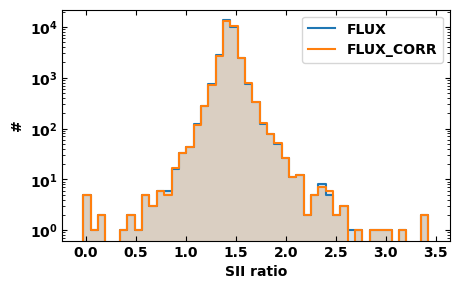

In [8]:
sii1_corr = table_muse['SII6716_FLUX_CORR'].value
sii2_corr = table_muse['SII6730_FLUX_CORR'].value
sii1_corr_err = table_muse['SII6716_FLUX_CORR_ERR'].value
sii2_corr_err = table_muse['SII6730_FLUX_CORR_ERR'].value

sii1 = table_muse['SII6716_FLUX'].value
sii2 = table_muse['SII6730_FLUX'].value
sii1_err = table_muse['SII6716_FLUX_ERR'].value
sii2_err = table_muse['SII6730_FLUX_ERR'].value

bins = np.linspace(-0.1, 3.5, 50)
bins1, bins_cent1, hist1 = get_hist(sii1/sii2, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(sii1_corr/sii2_corr, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid', label='FLUX')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ax.plot(bins_cent2, hist2, ds='steps-mid', label='FLUX_CORR')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.set_yscale('log')

ax.set_xlabel("SII ratio")
ax.set_ylabel("#")

ax.legend()

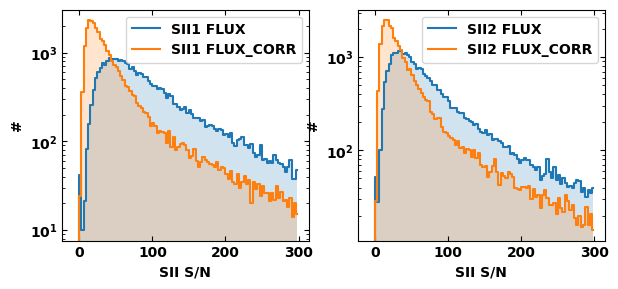

In [16]:
sii1 = table_muse['SII6716_FLUX'].value
sii2 = table_muse['SII6730_FLUX'].value
sii1_corr = table_muse['SII6716_FLUX_CORR'].value
sii2_corr = table_muse['SII6730_FLUX_CORR'].value

sii1_err = table_muse['SII6716_FLUX_ERR'].value
sii2_err = table_muse['SII6730_FLUX_ERR'].value
sii1_corr_err = table_muse['SII6716_FLUX_CORR_ERR'].value
sii2_corr_err = table_muse['SII6730_FLUX_CORR_ERR'].value

bins = np.linspace(-10, 300, 100)
bins1, bins_cent1, hist1 = get_hist(sii1/sii1_err, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(sii1_corr/sii1_corr_err, bins=bins, norm=False)
bins3, bins_cent3, hist3 = get_hist(sii2/sii2_err, bins=bins, norm=False)
bins4, bins_cent4, hist4 = get_hist(sii2_corr/sii2_corr_err, bins=bins, norm=False)

fig = plt.figure(figsize=(7, 3))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(bins_cent1, hist1, ds='steps-mid', label='SII1 FLUX')
ax1.plot(bins_cent2, hist2, ds='steps-mid', label='SII1 FLUX_CORR')
ax2.plot(bins_cent3, hist3, ds='steps-mid', label='SII2 FLUX')
ax2.plot(bins_cent4, hist4, ds='steps-mid', label='SII2 FLUX_CORR')

ax1.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')
ax1.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')
ax2.fill_between(bins_cent3, hist3, alpha=0.2, step='mid')
ax2.fill_between(bins_cent4, hist4, alpha=0.2, step='mid')

for ax in [ax1,ax2]:

    ax.set_yscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("SII S/N")
    ax.set_ylabel("#")
    ax.legend()

Error correction factor [SII]: 0.679


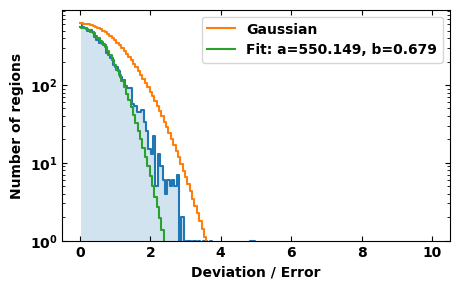

In [118]:
# Get SII error correction factor from all MUSE data (need for statistics)

sii1 = table_muse['SII6716_FLUX_CORR'].value
sii2 = table_muse['SII6730_FLUX_CORR'].value
sii1_err = table_muse['SII6716_FLUX_CORR_ERR'].value
sii2_err = table_muse['SII6730_FLUX_CORR_ERR'].value
t_n2 = table_muse['t_N2'].value
t_n2[t_n2.mask] = 8000 

isHII = table_muse['HII_class_v3'] == 1
mask = (sii1 > 0) & (sii2 > 0) & isHII

sii_ratio = sii1 / sii2
sii_ratio_err = sii_ratio * np.sqrt((sii1_err / sii1)**2 + (sii2_err / sii2)**2)
sii_ratio_ll = sii_ratio_ll_func(t_n2)
# sii_ratio_ll = 1.48922887 - 3.94351016e-6 * t_n2 # Don't know where this comes from... 
# sii_ratio_ll = 1.4484 # Sanders et al (2016, ApJ, 816, 23)

sii_ratio_lldiff = sii_ratio - sii_ratio_ll 
sii_ratio_lldifferr = sii_ratio_lldiff / sii_ratio_err

sii_ratio = sii_ratio[mask]
sii_ratio_err = sii_ratio_err[mask]
sii_ratio_lldiff = sii_ratio_lldiff[mask]
sii_ratio_lldifferr = sii_ratio_lldifferr[mask]

bins = np.linspace(0, 10, 150)
bins1, bins_cent1, hist1 = get_hist(sii_ratio_lldifferr[sii_ratio_lldifferr >= 0], bins=bins, norm=False)
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ax.plot(bins, func(bins, np.nanmax(hist1), 1), ds='steps-mid', label='Gaussian')

ax.set_yscale('log')
ax.set_ylim(1.0, np.nanmax(hist1)*1.5)

popt, pcov = curve_fit(func, bins_cent1, hist1, p0=[np.nanmax(hist1), 1])
ax.plot(bins, func(bins, *popt), ds='steps-mid', label='Fit: a=%5.3f, b=%5.3f' %tuple(popt))

ax.legend()

ax.set_xlabel("Deviation / Error")
ax.set_ylabel("Number of regions")

error_factor = popt[1]
print('Error correction factor [SII]: %0.3f' %error_factor)

Error correction factor [SII]: 1.530


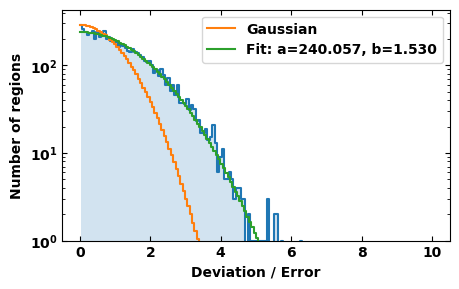

In [108]:
# Get SII error correction factor from all MUSE data (need for statistics)

sii1 = table_muse['SII6716_FLUX'].value
sii2 = table_muse['SII6730_FLUX'].value
sii1_err = table_muse['SII6716_FLUX_ERR'].value
sii2_err = table_muse['SII6730_FLUX_ERR'].value
t_n2 = table_muse['t_N2'].value
t_n2[t_n2.mask] = 8000 

isHII = table_muse['HII_class_v3'] == 1
mask = (sii1 > 0) & (sii2 > 0) & isHII

sii_ratio = sii1 / sii2
sii_ratio_err = sii_ratio * np.sqrt((sii1_err / sii1)**2 + (sii2_err / sii2)**2)
sii_ratio_ll = sii_ratio_ll_func(t_n2)
# sii_ratio_ll = 1.48922887 - 3.94351016e-6 * t_n2 # Don't know where this comes from... 
# sii_ratio_ll = 1.4484 # Sanders et al (2016, ApJ, 816, 23)

sii_ratio_lldiff = sii_ratio - sii_ratio_ll 
sii_ratio_lldifferr = sii_ratio_lldiff / sii_ratio_err

sii_ratio = sii_ratio[mask]
sii_ratio_err = sii_ratio_err[mask]
sii_ratio_lldiff = sii_ratio_lldiff[mask]
sii_ratio_lldifferr = sii_ratio_lldifferr[mask]

bins = np.linspace(0, 10, 150)
bins1, bins_cent1, hist1 = get_hist(sii_ratio_lldifferr[sii_ratio_lldifferr >= 0], bins=bins, norm=False)
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ax.plot(bins, func(bins, np.nanmax(hist1), 1), ds='steps-mid', label='Gaussian')

ax.set_yscale('log')
ax.set_ylim(1.0, np.nanmax(hist1)*1.5)

popt, pcov = curve_fit(func, bins_cent1, hist1, p0=[np.nanmax(hist1), 1])
ax.plot(bins, func(bins, *popt), ds='steps-mid', label='Fit: a=%5.3f, b=%5.3f' %tuple(popt))

ax.legend()

ax.set_xlabel("Deviation / Error")
ax.set_ylabel("Number of regions")

error_factor = popt[1]
print('Error correction factor [SII]: %0.3f' %error_factor)

Text(0, 0.5, 'Number of regions')

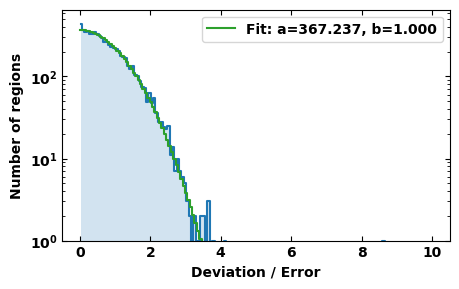

In [115]:
# Get SII error correction factor from all MUSE data (need for statistics)

root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
table_muse = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3.fits' %root_dir) 

sii1 = table_muse['SII6716_FLUX'].value
sii2 = table_muse['SII6730_FLUX'].value
sii1_err = table_muse['SII6716_FLUX_ERR'].value * error_factor
sii2_err = table_muse['SII6730_FLUX_ERR'].value * error_factor

t_n2 = table_muse['t_N2'].value
t_n2[t_n2.mask] = 8000 

isHII = table_muse['HII_class_v3'] == 1
mask = (sii1 > 0) & (sii2 > 0) & isHII

sii_ratio = sii1 / sii2
sii_ratio_err = sii_ratio * np.sqrt((sii1_err / sii1)**2 + (sii2_err / sii2)**2) 
sii_ratio_ll = sii_ratio_ll_func(t_n2)

sii_ratio_lldiff = sii_ratio - sii_ratio_ll 
sii_ratio_lldifferr = sii_ratio_lldiff / sii_ratio_err

sii_ratio = sii_ratio[mask]
sii_ratio_err = sii_ratio_err[mask]
sii_ratio_lldiff = sii_ratio_lldiff[mask]
sii_ratio_lldifferr = sii_ratio_lldifferr[mask]

bins = np.linspace(0, 10, 150)
bins1, bins_cent1, hist1 = get_hist(sii_ratio_lldifferr[sii_ratio_lldifferr >= 0], bins=bins, norm=False)
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

popt, pcov = curve_fit(func, bins_cent1, hist1, p0=[np.nanmax(hist1), 1])
ax.plot(bins, func(bins, *popt), ds='steps-mid', c='C2', label='Fit: a=%5.3f, b=%5.3f' %tuple(popt))

ax.set_yscale('log')
ax.set_ylim(1.0, np.nanmax(hist1)*1.5)
ax.legend()
ax.set_xlabel("Deviation / Error")
ax.set_ylabel("Number of regions")

In [28]:
# Determine the electron density for the SII regions for HST catalogue...

sii1 = table['SII6716_FLUX_MUSE'].value
sii2 = table['SII6730_FLUX_MUSE'].value
sii1_corr = table['SII6716_FLUX_CORR_MUSE'].value
sii2_corr = table['SII6730_FLUX_CORR_MUSE'].value

sii1_err = table['SII6716_FLUX_ERR_MUSE'].value
sii2_err = table['SII6730_FLUX_ERR_MUSE'].value
sii1_corr_err = table['SII6716_FLUX_CORR_ERR_MUSE'].value
sii2_corr_err = table['SII6730_FLUX_CORR_ERR_MUSE'].value

t_n2 = table['t_N2_MUSE'].value
t_n2[t_n2.mask] = 8000 

isHII = table['HII_class_v3_MUSE'] == True
mask = (sii1 > 0) & (sii2 > 0) & isHII

sii_ratio = sii1 / sii2
sii_corr_ratio = sii1_corr/sii2_corr

sii_ratio_err = sii_ratio * np.sqrt((sii1_err / sii1)**2 + (sii2_err / sii2)**2)
sii_ratio_ll = sii_ratio_ll_func(t_n2)

mask1 = (sii_ratio > 0) 
mask2 = (sii_ratio < sii_ratio_ll - (3*sii_ratio_err))
mask_tot = ((mask1) & (mask2) & (mask))

S2 = pn.Atom('S', 2)
ne = S2.getTemDen(sii_corr_ratio, tem=t_n2, wave1=6716, wave2=6730) # Corrected fluxes here... 
ne_noncorr = S2.getTemDen(sii_ratio, tem=t_n2, wave1=6716, wave2=6730) # Not corrected fluxes here (just to check)... 

table['ne'] = ne * u.cm**-3
table['ne'][~mask_tot] = np.nan # Apply mask.. 

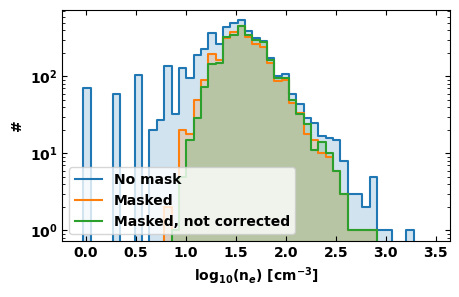

In [31]:
bins = np.linspace(-0.1, 3.5, 50)
bins1, bins_cent1, hist1 = get_hist(np.log10(table['ne'].value), bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(np.log10(ne), bins=bins, norm=False)
bins3, bins_cent3, hist3 = get_hist(np.log10(ne_noncorr[mask_tot]), bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)

ax.plot(bins_cent2, hist2, ds='steps-mid', label='No mask')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.plot(bins_cent1, hist1, ds='steps-mid', label='Masked')
ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

ax.plot(bins_cent3, hist3, ds='steps-mid', label='Masked, not corrected')
ax.fill_between(bins_cent3, hist3, alpha=0.2, step='mid')

ax.set_yscale('log')
ax.set_xlabel("log$_{10}$(n$_e$) [cm$^{-3}$]")
ax.set_ylabel("#")
ax.legend()

# GET BOLO LUMINOSITY

In [ ]:
"""Get SB99 models"""
inputdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/sb99/fiducial/fiducial_6p0linear' 

names_quanta = ['TIME', 'QHI', 'QHIf', 'QHeI', 'QHeIf', 'QHeII', 'QHeIIf', 'logL']
names_power = ['TIME', 'ALLp', 'OBp', 'RSGp', 'LBVp', 'WRp', 'ALLe', 'ALLm', 'OBm', 'RSGm', 'LBVm', 'WRm']
names_yield  = ['TIME', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Mdotwind', 'Mdotsne','Mdotboth', 'Mtot']


t_ewidth = QTable.read('%s/fiducial_6p0linear.ewidth1' %(inputdir), format='ascii', header_start=3, data_start=4)
t_quanta = QTable.read('%s/fiducial_6p0linear.quanta1' %(inputdir), format='ascii', data_start=5, names=names_quanta)
t_power = QTable.read('%s/fiducial_6p0linear.power1' %(inputdir), format='ascii', data_start=5, names=names_power)
t_yield = QTable.read('%s/fiducial_6p0linear.yield1' %(inputdir), format='ascii', data_start=5, names=names_yield)

tmax = 10 *u.Myr
tmin = 0 *u.Myr
time = t_ewidth['TIME']
time.unit = u.yr
time = time.to('Myr')
mask = ((time>tmin) & (time<tmax))
time = time[mask]
Q = t_quanta['QHI'][mask]
Mdot = t_yield['Mdotwind'][mask]
Lmech = t_power['ALLp'][mask]
Lbol = t_quanta['logL'][mask]
LHa = t_ewidth['LUM(H_A)'][mask]
Lfrac_array = 10**(t_quanta['logL'][mask]-t_ewidth['LUM(H_A)'][mask])

age = table['reg_dolflux_Age_MinChiSq']
age.unit = u.Myr 

# Determine the Lbol/LHa ratio for the HST regions...
Lfrac = np.empty(len(age)) *np.nan 
for i in range(len(age)):
    _, id_ = find_nearest(time.value, age.value[i])
    if id_==0:
        continue
    Lfrac[i] = Lfrac_array[id_]
    
table['Lbol/LHa'] = Lfrac *u.dimensionless_unscaled

In [ ]:
def get_Lbol(Lha, conv=138):
    return conv*Lha

KE12_conv = 138 # with constant Kennicutt & Evans (2012) - also Lopez et al. (2014)
B21_conv = 88.2 # with constant conversion from Barnes21
low_conv = 17.684 # with lower limit from ionising photons only

Lbol      = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=table['Lbol/LHa'])
Lbol_KE12 = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=KE12_conv) 
Lbol_B21  = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=B21_conv)
Lbol_low  = get_Lbol(table['HA6562_LUMINOSITY_HST'], conv=low_conv) 

table['Lbol'] = Lbol
table['Lbol_KE12'] = Lbol_KE12
table['Lbol_B21'] = Lbol_B21
table['Lbol_low'] = Lbol_low

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

ax.plot(time, np.log10(Lfrac_array))
ax.fill_between(time.value, np.log10(Lfrac_array.value), alpha=0.2)


ax.plot([0,10], np.log10([KE12_conv, KE12_conv]), label='KE12 = %0.1f' %KE12_conv, ls='--')
ax.plot([0,10], np.log10([B21_conv, B21_conv]), label='B21 = %0.1f' %B21_conv, ls='--')
ax.plot([0,10], np.log10([low_conv, low_conv]), label='low = %0.1f' %low_conv, ls='--')

ax.set_xlim([0,9.9])
ax.set_ylim([0,3.7])
ax.set_xlabel('time (Myr)')
ax.set_ylabel('log(Lbol/Lha)')
ax.legend()

ax.grid(alpha=0.3, linestyle=':')

In [ ]:
Lfrac_masked = Lfrac[age<=5*u.Myr]

bins = np.linspace(0, 300, 30)
bins1, bins_cent1, hist1 = get_hist(Lfrac, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(Lfrac_masked, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid', c='black', label='All')
ax.plot(bins_cent2, hist2, ds='steps-mid', label='<=5Myr')

ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', color='black')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.set_xlabel("L$_{bol}$/L$_{H\\alpha}$")
ax.set_ylabel("#")
ax.legend()

In [ ]:
Lbol_masked = Lbol[age<=5*u.Myr]

bins = np.linspace(37,45,50)
bins1, bins_cent1, hist1 = get_hist(np.log10(Lbol.value), bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(np.log10(Lbol_masked.value), bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(111)
ax.plot(bins_cent1, hist1, ds='steps-mid', c='black', label='All')
ax.plot(bins_cent2, hist2, ds='steps-mid', label='<=5Myr')

ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', color='black')
ax.fill_between(bins_cent2, hist2, alpha=0.2, step='mid')

ax.set_yscale('log')

ax.set_xlabel("log$_{10}$(L$_{bol}$) [erg s$^{-1}$]")
ax.set_ylabel("#")
ax.legend()

# GET IONISATION RATE and Rstrom

In [ ]:
def get_reccoeff(temp):
    alpha = 2.753e-14 * (315614 /  temp)**1.500 / ((1.0 + (115188 / temp)**0.407)**2.242)
    return(alpha*u.cm**3/u.s)

plt.plot(np.linspace(5000,15000,100), get_reccoeff(np.linspace(5000,15000,100)))
plt.xlabel('Temperature')
plt.ylabel('Recombination coefficient')

In [ ]:
def get_rstrom(Q, rec_coeff, ne):
    r_strom = ((3/(4*np.pi)) * (Q/(rec_coeff*ne**2)))**(1/3)
    return(r_strom)

ha_lum = table['HA6562_LUMINOSITY_HST']
radius_circ_pc = table['radius_circ_pc']
t_n2 = table['t_N2_MUSE'].value
t_n2[t_n2.mask] = 8000 

ha_photon_energy = (1.89 *u.eV).to('erg')   # Energy in erg of single H-alpha photon (https://en.wikipedia.org/wiki/Balmer_series)
ha_rate = ha_lum / ha_photon_energy         # Emission rate (in photons per s) of H-alpha
Q = ha_rate / 0.45                          # Per Calzetti (2012), ~45% of recombinations result in emission of an H-alpha photon

rec_coeff = get_reccoeff(t_n2)
radius_strom_pc = get_rstrom(Q, rec_coeff, table['ne']).to('pc')

table['rec_coeff'] = rec_coeff
table['Q'] = Q
table['radius_strom_pc'] = radius_strom_pc

# GET PRESSURES

## Pdir + Ptherm

In [ ]:
def get_Pdir(Lbol, r):
    """Taken from Lopez et al. (2014)"""
    Pdir = (3/(4*np.pi)) * (Lbol/(r**2*const.c)) 
    Pdir = Pdir/const.k_B
    return Pdir.to('K/cm^3')

def get_Ptherm(ne, temp, ionisation=2):
    """ionisation=2 assumes single ionised He"""
    Ptherm = const.k_B*ne*temp*ionisation
    Ptherm = Ptherm/const.k_B
    return Ptherm.to('K/cm^3')

In [ ]:
radius_circ_pc  = table['radius_circ_pc']
radius_mom_pc   = table['mean_sigma_pc']
radius_strom_pc = table['radius_strom_pc']

Pdir_circ  = get_Pdir(Lbol, radius_circ_pc)
Pdir_mom   = get_Pdir(Lbol, radius_mom_pc)
Pdir_strom = get_Pdir(Lbol, radius_strom_pc)

Pdir_circ_Lbol_B21  = get_Pdir(Lbol_B21, radius_circ_pc)
Pdir_mom_Lbol_B21   = get_Pdir(Lbol_B21, radius_mom_pc)
Pdir_circ_Lbol_KE12  = get_Pdir(Lbol_KE12, radius_circ_pc)
Pdir_mom_Lbol_KE12   = get_Pdir(Lbol_KE12, radius_mom_pc)

table['Pdir_circ']  = Pdir_circ
table['Pdir_mom']   = Pdir_mom
table['Pdir_strom'] = Pdir_strom

table['Pdir_circ_Lbol_B21']  = Pdir_circ_Lbol_B21
table['Pdir_mom_Lbol_B21']   = Pdir_mom_Lbol_B21
table['Pdir_circ_Lbol_KE12']  = Pdir_circ_Lbol_KE12
table['Pdir_mom_Lbol_KE12']   = Pdir_mom_Lbol_KE12

In [ ]:
ne = table['ne']
t_n2 = table['t_N2_MUSE'].value
t_n2[t_n2.mask] = 8000 
t_n2 = t_n2 * u.K

Ptherm = get_Ptherm(ne, t_n2)
table['Ptherm'] = Ptherm

In [ ]:
table.write('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_wclusters_wprops.fits' %root_dir, overwrite=True)

## Pwind

In [ ]:
# TODO